# Task 8 - Manual Data Collection


In [1]:
import os
import sys
import time
from pathlib import Path
from datetime import datetime

import numpy as np
import pybullet as p

current = Path.cwd()
if (current / 'notebooks').exists():
    PROJECT_ROOT = current
else:
    PROJECT_ROOT = current.parent

os.chdir(PROJECT_ROOT)

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from scripts.task_7_env import Task7PendulumEnv, Y_MAX

DATA_DIR = Path('data')
MODELS_DIR = DATA_DIR
for directory in (DATA_DIR, MODELS_DIR):
    directory.mkdir(exist_ok=True)

print('Project root:', PROJECT_ROOT)


pybullet build time: Dec  4 2025 20:11:42


Project root: /home/acepeax/Desktop/Studies/MVA/Robotics/Project


In [2]:
MAX_STEPS = 1800
SHOULD_BALANCE = False
SIM_SUBSTEPS = 6
PENALIZE_POSITION = False
GUI = True  # GUI required for keyboard input
MANUAL_DATA_DIR = DATA_DIR / 'task8_manual'
MANUAL_DATA_DIR.mkdir(parents=True, exist_ok=True)
DEFAULT_INITIAL_PENDULUM_ANGLE = 0.0


def make_task8_env(
    gui=GUI,
    sim_substeps=SIM_SUBSTEPS,
    penalize_position=PENALIZE_POSITION,
    initial_angle=DEFAULT_INITIAL_PENDULUM_ANGLE,
):
    def _init():
        return Task7PendulumEnv(
            max_steps=MAX_STEPS,
            should_balance=False,
            gui=gui,
            sim_substeps=sim_substeps,
            penalize_position=penalize_position,
            initial_pendulum_angle=initial_angle,
        )

    return _init


env_fn = make_task8_env()


In [3]:
KEY_TO_ACTION = {
    p.B3G_LEFT_ARROW: 0,
    p.B3G_UP_ARROW: 1,
    p.B3G_RIGHT_ARROW: 2,
}
RESET_KEY = ord('r')
EXIT_KEY = 65307  # ESC key code in PyBullet keyboard events


def keyboard_action(env, prev_action=1):
    if not p.isConnected():
        raise KeyboardInterrupt('PyBullet disconnected')
    try:
        keys = p.getKeyboardEvents()
    except p.error as exc:
        raise KeyboardInterrupt('PyBullet disconnected') from exc
    action = prev_action
    for key, idx in KEY_TO_ACTION.items():
        if key in keys and keys[key] & p.KEY_IS_DOWN:
            action = idx
    if RESET_KEY in keys and keys[RESET_KEY] & p.KEY_WAS_TRIGGERED:
        env.reset()
        print('Manual reset triggered')
    if EXIT_KEY in keys and keys[EXIT_KEY] & p.KEY_WAS_TRIGGERED:
        raise KeyboardInterrupt('Exit pressed')
    return action


def save_episode(data_dir, tag, observations, actions, rewards):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    path = data_dir / f"task8_{tag}_{timestamp}.npz"
    np.savez(
        path,
        observations=np.asarray(observations, dtype=np.float32),
        actions=np.asarray(actions, dtype=np.int32),
        rewards=np.asarray(rewards, dtype=np.float32),
    )
    print('Saved to', path)


def run_manual_episode(env, tag='swingup', save=True, data_dir=MANUAL_DATA_DIR):
    obs, _ = env.reset()
    done = False
    action = 1
    observations, actions, rewards = [], [], []
    print('Arrow keys control the end-effector target. R resets, ESC quits.')
    try:
        while not done:
            action = keyboard_action(env, action)
            obs, reward, terminated, truncated, info = env.step(action)
            observations.append(obs.copy())
            actions.append(action)
            rewards.append(reward)
            done = terminated or truncated
            time.sleep(env.dt)
    except KeyboardInterrupt as exc:
        print(exc)
    finally:
        if save and observations:
            save_episode(data_dir, tag, observations, actions, rewards)
    return observations, actions, rewards


In [5]:
env = env_fn()
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)
obs, actions, rewards = run_manual_episode(env, tag="trial1")
print(f"Collected {len(actions)} steps")
env.close()

argv[0]=--minLoggingLevel=3
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=3
argv[0] = --unused
argv[1] = --minLoggingLevel=3
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
GL_VERSION=4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
Vendor = Intel
Renderer = Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
ven = Intel
Workaroun

: 

## Analyzing the recording

In [4]:
import matplotlib.pyplot as plt

In [5]:
def review_recording(record_file=None, plot=True):
    recordings = sorted(MANUAL_DATA_DIR.glob('task8_*.npz'))
    if not recordings:
        raise FileNotFoundError('No recordings found in ' + str(MANUAL_DATA_DIR))
    if record_file is None:
        record_file = recordings[-1]
    else:
        record_file = Path(record_file)
    if not record_file.exists():
        raise FileNotFoundError(record_file)
    data = np.load(record_file)
    obs = data['observations']
    actions = data['actions']
    rewards = data['rewards']
    print(f'Loaded {record_file.name}: {len(obs)} steps')
    if plot:
        steps = np.arange(len(obs))
        angles = obs[:, 0]
        angle_dot = obs[:, 1]
        y_pos = obs[:, 9]
        y_vel = obs[:, 12]
        fig, axes = plt.subplots(4, 1, figsize=(14, 8), sharex=True)
        axes[0].plot(steps, angles, label='pend angle (rad)')
        axes[0].legend(); axes[0].grid(True); axes[0].set_ylabel('angle')
        axes[1].plot(steps, angle_dot, label='pend angle_dot (rad/s)')
        axes[1].legend(); axes[1].grid(True); axes[1].set_ylabel('ang vel')
        axes[2].plot(steps, y_pos, label='ee y (m)', color='tab:orange')
        axes[2].legend(); axes[2].grid(True); axes[2].set_ylabel('y pos')
        axes[3].plot(steps, y_vel, label='ee y_dot (m/s)', color='tab:red')
        axes[3].legend(); axes[3].grid(True); axes[3].set_ylabel('y vel'); axes[3].set_xlabel('step')
        fig.suptitle(f'Pendulum + end-effector traces: {record_file.name}')
        plt.tight_layout()
        plt.show()
    return record_file, obs, actions, rewards


Loaded task8_trial1_20251209_132341.npz: 122 steps


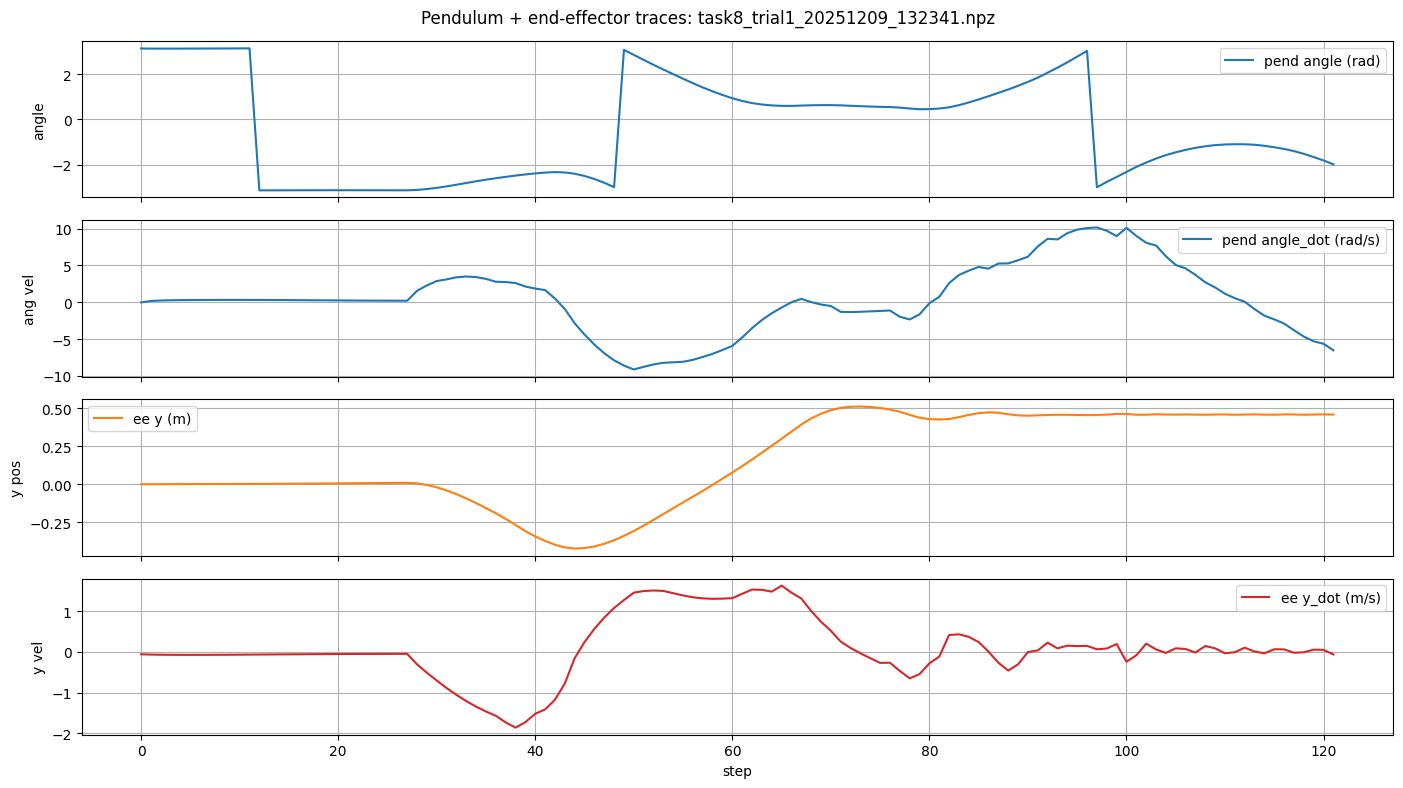

First 5 actions: [1 1 1 1 1]


In [6]:
record_file, obs, actions, rewards = review_recording()
print('First 5 actions:', actions[:5])


In [7]:
def rollout_from_file(record_file=None, gui=True, realtime=True, start_step=0, max_steps=None):
    """Replay discrete actions in a fresh env GUI.
    start_step skips the first steps, max_steps truncates playback length.
    Only actions are applied; joint states are not restored.
    """
    recordings = sorted(MANUAL_DATA_DIR.glob('task8_*.npz'))
    if not recordings:
        raise FileNotFoundError('No recordings found in ' + str(MANUAL_DATA_DIR))
    if record_file is None:
        record_file = recordings[-1]
    else:
        record_file = Path(record_file)
    if not record_file.exists():
        raise FileNotFoundError(record_file)
    data = np.load(record_file)
    obs = data['observations']
    actions = data['actions']
    rewards = data['rewards']
    total_available = len(actions)
    if start_step < 0 or start_step >= total_available:
        raise ValueError(f'start_step {start_step} outside [0, {total_available})')
    end_step = total_available if max_steps is None else min(total_available, start_step + int(max_steps))
    print(f'Replaying {record_file.name} steps {start_step}..{end_step-1} / {total_available}')
    start_idx = min(start_step, len(obs) - 1)
    initial_axis_angle = float(obs[start_idx][0]) + np.pi
    env_view = make_task8_env(gui=gui, initial_angle=initial_axis_angle)()
    env_view.reset()
    try:
        if start_step > 0:
            print(f'Skipping first {start_step} steps')
        for step in range(start_step, end_step):
            record_obs = obs[step]
            action = actions[step]
            pend_angle = float(record_obs[0])
            y_pos = float(record_obs[9])
            print(f'Step {step:04d} | action={action} pend={pend_angle:+.3f} y={y_pos:+.3f}')
            env_view.step(int(action))
            if gui and realtime:
                time.sleep(env_view.dt)
    finally:
        env_view.close()
    return record_file


In [8]:
rollout_from_file(gui=True, max_steps=80)

Replaying task8_trial1_20251209_132341.npz steps 0..79 / 122
argv[0]=--minLoggingLevel=3
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=3
argv[0] = --unused
argv[1] = --minLoggingLevel=3
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
GL_VERSION=4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
Vendor = Intel
Renderer = Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Intel
Workaround for some crash in 

PosixPath('data/task8_manual/task8_trial1_20251209_132341.npz')

## Recording finetuning


In [9]:
def load_recording(record_file=None):
    recordings = sorted(MANUAL_DATA_DIR.glob('task8_*.npz'))
    if not recordings:
        raise FileNotFoundError('No recordings found in ' + str(MANUAL_DATA_DIR))
    if record_file is None:
        record_file = recordings[-1]
    else:
        record_file = Path(record_file)
    if not record_file.exists():
        raise FileNotFoundError(record_file)
    data = np.load(record_file)
    obs = np.array(data['observations'], copy=True)
    actions = np.array(data['actions'], copy=True)
    rewards = np.array(data['rewards'], copy=True)
    return record_file, {'observations': obs, 'actions': actions, 'rewards': rewards}


def trim_recording(record_data, start=0, end=None):
    obs = record_data['observations']
    n = len(obs)
    if end is None or end > n:
        end = n
    if start < 0 or start >= end:
        raise ValueError(f'Invalid trim range [{start}, {end}) for length {n}')
    sl = slice(start, end)
    return {
        'observations': record_data['observations'][sl].copy(),
        'actions': record_data['actions'][sl].copy(),
        'rewards': record_data['rewards'][sl].copy(),
    }


def append_actions(record_data, extra_actions):
    extra_actions = np.asarray(extra_actions, dtype=np.int32).ravel()
    if extra_actions.size == 0:
        return {k: np.array(v, copy=True) for k, v in record_data.items()}
    obs = record_data['observations']
    actions = record_data['actions']
    rewards = record_data['rewards']
    initial_angle = float(obs[0][0]) + np.pi if len(obs) > 0 else DEFAULT_INITIAL_PENDULUM_ANGLE
    env_view = make_task8_env(gui=False, initial_angle=initial_angle)()
    obs_env, _ = env_view.reset()
    try:
        for action in actions:
            obs_env, reward_env, terminated, truncated, info = env_view.step(int(action))
            if terminated or truncated:
                break
        new_obs = []
        new_rewards = []
        executed_actions = []
        for action in extra_actions:
            obs_env, reward_env, terminated, truncated, info = env_view.step(int(action))
            new_obs.append(obs_env.copy())
            new_rewards.append(reward_env)
            executed_actions.append(int(action))
            if terminated or truncated:
                print('Recording extension stopped early (episode ended).')
                break
    finally:
        env_view.close()
    if not new_obs:
        print('No additional actions were appended.')
        return {k: np.array(v, copy=True) for k, v in record_data.items()}
    return {
        'observations': np.concatenate([obs, np.asarray(new_obs, dtype=np.float32)], axis=0),
        'actions': np.concatenate([actions, np.asarray(executed_actions, dtype=np.int32)], axis=0),
        'rewards': np.concatenate([rewards, np.asarray(new_rewards, dtype=np.float32)], axis=0),
    }


def save_recording(record_data, output_path=None, reference_file=None, suffix='edited'):
    if output_path is None:
        base = reference_file.stem if reference_file else 'task8_manual'
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        output_path = MANUAL_DATA_DIR / f"{base}_{suffix}_{timestamp}.npz"
    np.savez(
        output_path,
        observations=record_data['observations'],
        actions=record_data['actions'],
        rewards=record_data['rewards'],
    )
    print('Saved edited recording to', output_path)
    return output_path


def rollout_recording_data(record_data, gui=True, realtime=True, start_step=0, max_steps=None):
    actions = record_data['actions']
    obs = record_data['observations']
    total = len(actions)
    if total == 0:
        raise ValueError('Recording has no actions')
    if start_step < 0 or start_step >= total:
        raise ValueError(f'start_step {start_step} outside [0, {total})')
    end = total if max_steps is None else min(total, start_step + int(max_steps))
    start_idx = min(start_step, len(obs) - 1)
    initial_axis_angle = float(obs[start_idx][0]) + np.pi
    env_view = make_task8_env(gui=gui, initial_angle=initial_axis_angle)()
    env_view.reset()
    try:
        for step in range(start_step, end):
            obs_idx = min(step, len(obs) - 1)
            record_obs = obs[obs_idx]
            action = int(actions[step])
            pend_angle = float(record_obs[0])
            y_pos = float(record_obs[9])
            print(f'Step {step:04d} | action={action} pend={pend_angle:+.3f} y={y_pos:+.3f}')
            env_view.step(action)
            if gui and realtime:
                time.sleep(env_view.dt)
    finally:
        env_view.close()


In [10]:
# Example finetuning workflow (adjust indices before running)
# record_path, data = load_recording()
# trimmed = trim_recording(data, start=200, end=800)
# extended = append_actions(trimmed, extra_actions=[1, 1, 2, 0, 0])
# rollout_recording_data(extended, gui=False, realtime=False)
# save_recording(extended, reference_file=record_path)


In [14]:
record_path, data = load_recording()
data = trim_recording(data, start=0, end=75)
data = append_actions(data, extra_actions=[0]*4)
data = append_actions(data, extra_actions=[1]*1)
data = append_actions(data, extra_actions=[0]*4)
data = append_actions(data, extra_actions=[1]*2)

argv[0]=--minLoggingLevel=3
argv[0]=--minLoggingLevel=3
argv[0]=--minLoggingLevel=3
argv[0]=--minLoggingLevel=3


In [15]:
rollout_recording_data(data, gui=True, realtime=False)

argv[0]=--minLoggingLevel=3
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=3
argv[0] = --unused
argv[1] = --minLoggingLevel=3
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
GL_VERSION=4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
Vendor = Intel
Renderer = Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
ven = Intel
Workaroun

In [28]:
save_recording(data, output_path="data/swing_up_demo.npz")

Saved edited recording to data/swing_up_demo.npz


'data/swing_up_demo.npz'

Loaded swing_up_demo.npz: 86 steps


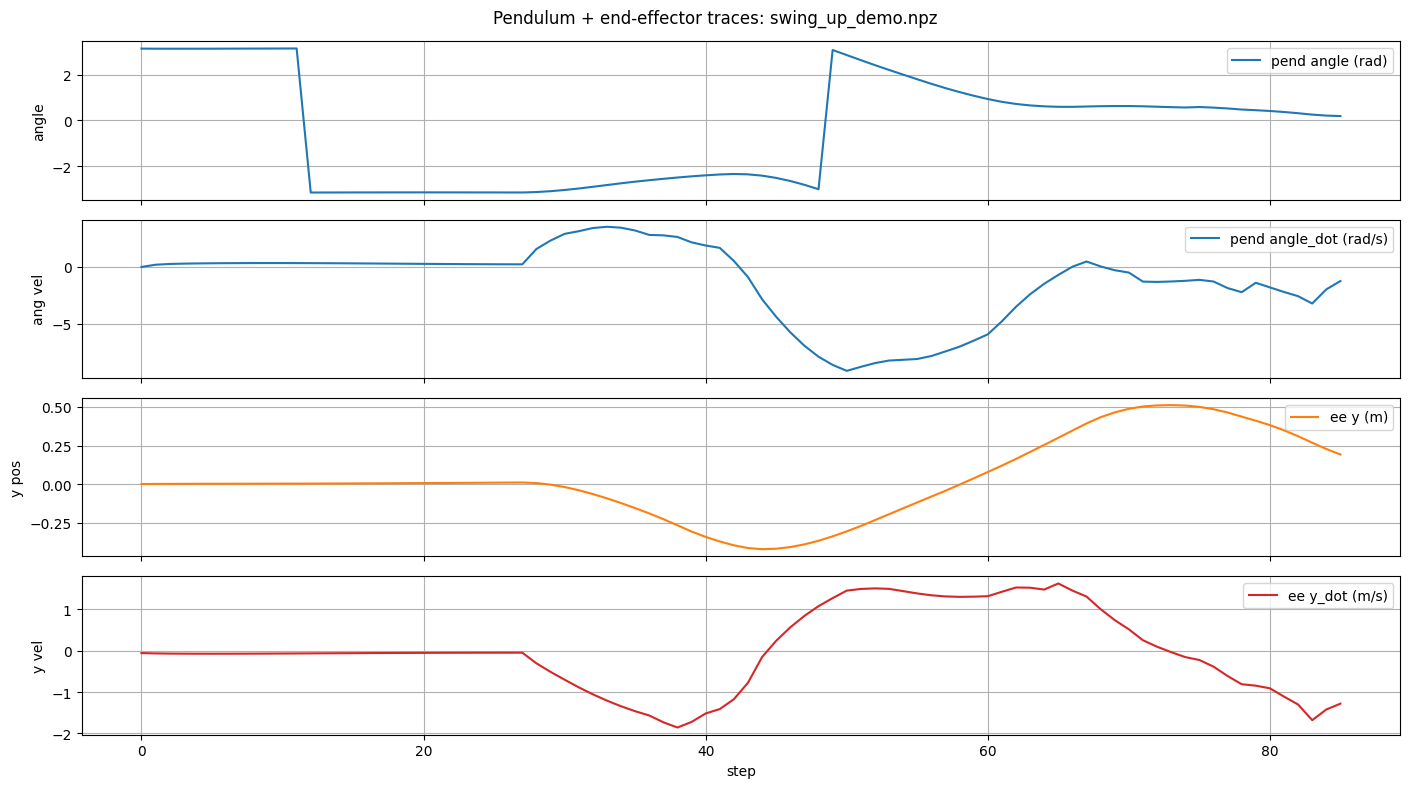

(PosixPath('data/swing_up_demo.npz'),
 array([[ 3.1335936 , -0.02992043,  0.5007165 , ...,  0.01561202,
         -0.05577947, -0.0236691 ],
        [ 3.1299074 ,  0.16694444,  0.5004085 , ...,  0.00768439,
         -0.0640729 , -0.08126441],
        [ 3.1288705 ,  0.23293433,  0.4998098 , ...,  0.00697077,
         -0.06800456, -0.10807164],
        ...,
        [ 0.2556898 , -3.2328963 ,  0.5317509 , ...,  1.1265808 ,
         -1.6784903 ,  0.10230999],
        [ 0.2135784 , -1.9936714 ,  0.5386794 , ...,  0.94943094,
         -1.4202079 ,  0.23801607],
        [ 0.19123739, -1.2618144 ,  0.5447899 , ...,  0.82517934,
         -1.2791312 ,  0.25852814]], shape=(86, 14), dtype=float32),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1],
       dtype=

In [43]:
review_recording(record_file="data/swing_up_demo.npz")

In [42]:
def rollout_from_file_with_capture(record_file=None, gui=True, realtime=True, start_step=0, max_steps=None):
    """Replay discrete actions in a fresh env GUI.
    start_step skips the first steps, max_steps truncates playback length.
    Only actions are applied; joint states are not restored.
    """
    recordings = sorted(MANUAL_DATA_DIR.glob('task8_*.npz'))
    if not recordings:
        raise FileNotFoundError('No recordings found in ' + str(MANUAL_DATA_DIR))
    if record_file is None:
        record_file = recordings[-1]
    else:
        record_file = Path(record_file)
    if not record_file.exists():
        raise FileNotFoundError(record_file)
    data = np.load(record_file)
    obs = data['observations']
    actions = data['actions']
    rewards = data['rewards']
    total_available = len(actions)
    if start_step < 0 or start_step >= total_available:
        raise ValueError(f'start_step {start_step} outside [0, {total_available})')
    end_step = total_available if max_steps is None else min(total_available, start_step + int(max_steps))
    print(f'Replaying {record_file.name} steps {start_step}..{end_step-1} / {total_available}')
    start_idx = min(start_step, len(obs) - 1)
    initial_axis_angle = float(obs[start_idx][0]) + np.pi
    env_view = make_task8_env(gui=gui, initial_angle=initial_axis_angle)()
    env_view.reset()
    try:
        if start_step > 0:
            print(f'Skipping first {start_step} steps')
        for step in range(start_step, end_step):
            record_obs = obs[step]
            action = actions[step]
            pend_angle = float(record_obs[0])
            y_pos = float(record_obs[9])
            print(f'Step {step:04d} | action={action} pend={pend_angle:+.3f} y={y_pos:+.3f}')
            if step in [0,40,53,60,79]:
                env_view.capture_snapshot(file_path="videos/demo/snapshot_"+str(step)+".png")
            env_view.step(int(action))
            if gui and realtime:
                time.sleep(env_view.dt)
    finally:
        env_view.close()
    return record_file
def rollout_recording_data_with_capture(record_data, gui=True, realtime=True, start_step=0, max_steps=None):
    actions = record_data['actions']
    obs = record_data['observations']
    total = len(actions)
    if total == 0:
        raise ValueError('Recording has no actions')
    if start_step < 0 or start_step >= total:
        raise ValueError(f'start_step {start_step} outside [0, {total})')
    end = total if max_steps is None else min(total, start_step + int(max_steps))
    start_idx = min(start_step, len(obs) - 1)
    initial_axis_angle = float(obs[start_idx][0]) + np.pi
    env_view = make_task8_env(gui=gui, initial_angle=initial_axis_angle)()
    env_view.reset()
    print("end",end)
    try:
        for step in range(start_step, end):
            obs_idx = min(step, len(obs) - 1)
            record_obs = obs[obs_idx]
            action = int(actions[step])
            pend_angle = float(record_obs[0])
            y_pos = float(record_obs[9])
            print(f'Step {step:04d} | action={action} pend={pend_angle:+.3f} y={y_pos:+.3f}')
            if step in [0,40,53,60,75,85]:
                env_view.capture_snapshot(file_path="videos/demo/snapshot_"+str(step)+".png")
            env_view.step(action)
            if gui and realtime:
                time.sleep(env_view.dt)
    finally:
        env_view.close()


In [44]:
rollout_recording_data_with_capture(data, gui=True, realtime=False)

argv[0]=--minLoggingLevel=3
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=3
argv[0] = --unused
argv[1] = --minLoggingLevel=3
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
GL_VERSION=4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
Vendor = Intel
Renderer = Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
ven = Intel
Workaroun